In [8]:
import sys
sys.path.insert(0, 'C:/Udvikler/Speciale/SpecialeKode')

from utils import * 
import pandas as pd
from RFQAgent import RFQAgent, DataTransformer
import numpy as np
from model_evaluation.RFQModelEval import RFQModelEval
from model_evaluation import eval_utilities as eval_utils
import itertools
from inventory_and_risk_engineering import add_inventory_and_risk

In [9]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

#Not to make the kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [10]:
#file_path = "data/data.csv"
#df = pd.read_csv(file_path)
#df = add_inventory_and_risk(df)

In [11]:
features = ["bpv_risk","DealersInCompetition", "BookName",  "AllQMeanMid"]
#"inventoryRisk",

# Read the CSV file into a pandas DataFrame
file_path = "data/data_inventory_risk.csv"
df = pd.read_csv(file_path)

#Set seed to replicate results
np.random.seed(41)

# Datetime format
df["TradeTime"] = pd.to_datetime(df["TradeTime"], format="%m/%d/%Y %H:%M:%S")

#Split into train and test set  
train_df, val_df = split_data(df, 0.9)

#Further split test into val and test, to make model selection
#val_df, test_df = split_data(test_df.copy(), 0.5)

### Iterate through feature, learning algorithms, number of bins and reward function combinations

('bpv_risk,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'QL')
number of different states in dataset: 226,
size of statespace: 256,
state coverage by trajectory: 0.8828
most frequent action:  26
Total unique states in test data: 143
Number of unseen states in test data: 0
Proportion of unseen states: 0.0
Desired HR: 22.871376811594203 

('bpv_risk,Side,DealersInCompetition,BookName,AllQMeanMid', 'risk_PnL_reward', 'DQL')
number of different states in dataset: 226,
size of statespace: 256,
state coverage by trajectory: 0.8828
most frequent action:  26
Total unique states in test data: 143
Number of unseen states in test data: 0
Proportion of unseen states: 0.0
Desired HR: 22.871376811594203 

('bpv_risk,Side,Duration,BookName,AllQMeanMid', 'risk_PnL_reward', 'QL')
number of different states in dataset: 192,
size of statespace: 256,
state coverage by trajectory: 0.75
most frequent action:  26
Total unique states in test data: 110
Number of unseen states in test data

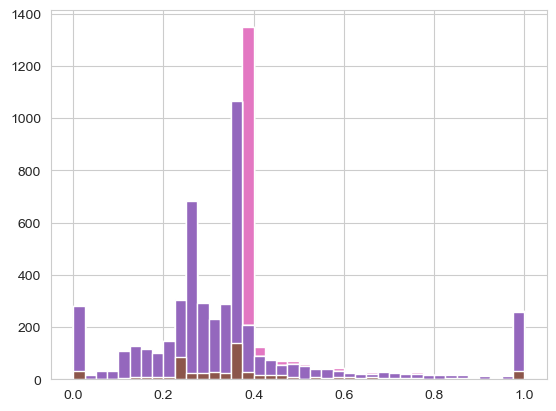

In [12]:

all_features = [
    #["DealersInCompetition", "FirmAccount", "IssuedAmount", "Oas", "BidAskSpread", "Side", "BookName", "KeyRatioPrice", "AllQMinMid", "AllQMaxMid", "AllQMeanMid", "MarketThicknes"],
    #["DealersInCompetition", "FirmAccount", "Side", "BookName", "AllQMinMid", "AllQMaxMid", "AllQMeanMid"],
    #["FirmAccount", "Oas", "BookName", "AllQMeanMid"],
    #["DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["KeyRatioPrice", "BookName", "AllQMeanMid"],
    #["bpv_risk", "Duration", "Price_Diff", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["bpv_risk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["bpv_risk", "Side", "Duration", "BookName",  "AllQMeanMid"],
    #["bpv_risk", "Side", "Price_Diff", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Duration", "Price_Diff", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    #["inventoryRisk", "Duration", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],
    ["inventoryRisk", "Side", "DealersInCompetition", "BookName",  "AllQMeanMid"],   
    ["inventoryRisk", "Side", "Duration", "BookName",  "AllQMeanMid"],   
    #["inventoryRisk", "Side", "Price_Diff", "DealersInCompetition", "BookName",  "AllQMeanMid"],
]

all_reward_functions = [
    #simpleSpreadReward,
    #linearMarginReward,
    #quadraticMarginReward,
    risk_PnL_reward,
    inventory_PnL_reward
]

learning_algorithms = [
    'QL',
    'DQL',
    #'QL_MarkovGame',
    #'double_QL_MarkovGame',
    #'random_by_action_distr',
    #'random_by_uniform' 
]

metrics = ["dealerHitRate", "mlHitRate", "MLWinShare", "mlDistToCoverMean", "mlDistToCoverStd", "dealerDistToCoverMean", 
           "meanMLProfit", "meanDealerProfit", "meanRLReward", "dealerD2TargetMean", "MLD2TargetMean", "MLD2TargetStd", "meanMLSharpeRatio",
           "meanDealerSharpeRatioNoNeg", "meanDealerSharpeRatio",  "DealerNetInventoryDiff", "MLNetInventoryDiff"]

# Convert each list of features to a single concatenated string
all_features_str = [",".join(features) for features in all_features]  # Join list of strings with commas

# Create a MultiIndex for the DataFrame using the combinations of parameters
index = pd.MultiIndex.from_tuples(
    [(features, reward_function.__name__, learning_algorithm)
     for features, reward_function, learning_algorithm in 
     itertools.product(all_features_str, all_reward_functions, learning_algorithms)
     if (("bpv_risk" not in features or reward_function.__name__ != "inventory_PnL_reward") and 
         ("inventoryRisk" not in features or reward_function.__name__ != "risk_PnL_reward"))],
    names=["Features", "Reward Function", "Learning Algorithm"]
)


# Initialize an empty DataFrame with the MultiIndex
results_df = pd.DataFrame(columns=metrics, index=index)

# Iterate over all combinations and collect results
for features, reward_function, learning_algorithm in itertools.product(all_features, all_reward_functions, learning_algorithms):
    
    # Apply the condition to skip unwanted combinations
    if ("bpv_risk" in features and reward_function.__name__ == "inventory_PnL_reward") or \
       ("inventoryRisk" in features and reward_function.__name__ == "risk_PnL_reward"):
        continue  
    

    # Convert features list to a single string
    features_key = ",".join(features)  # Join list of strings with commas
    key = (features_key, reward_function.__name__, learning_algorithm)
    
    print(key)
    
    opponent_actions = learning_algorithm in ["QL_MarkovGame", "double_QL_MarkovGame"]
    
    # Perform the experiment (replace with your actual code)
    data_transformer = DataTransformer(
        input_features=features, lower_spread_limit=-0.005, upper_spread_limit=0.15, num_bins=4,
        discretize_method="number", reward_function=reward_function, opponent_actions=opponent_actions,
        vectorize_next_state=False, reward_terms=False)
    
    agent = RFQAgent(data_transformer=data_transformer)
    agent.train(train_df.copy(), algorithm=learning_algorithm)

    modelEvaluator = RFQModelEval(agent)
    modelPerformance = modelEvaluator.eval(val_df.copy(), algorithm=learning_algorithm, print_post_trade=True, 
                                           print_violin_plot=False, random_policy=False)
    

    # Collect and store the relevant metrics
    results_df.loc[key] = modelPerformance[metrics]  # Example of storing mean values

# Display the results DataFrame
print(results_df)

                                        

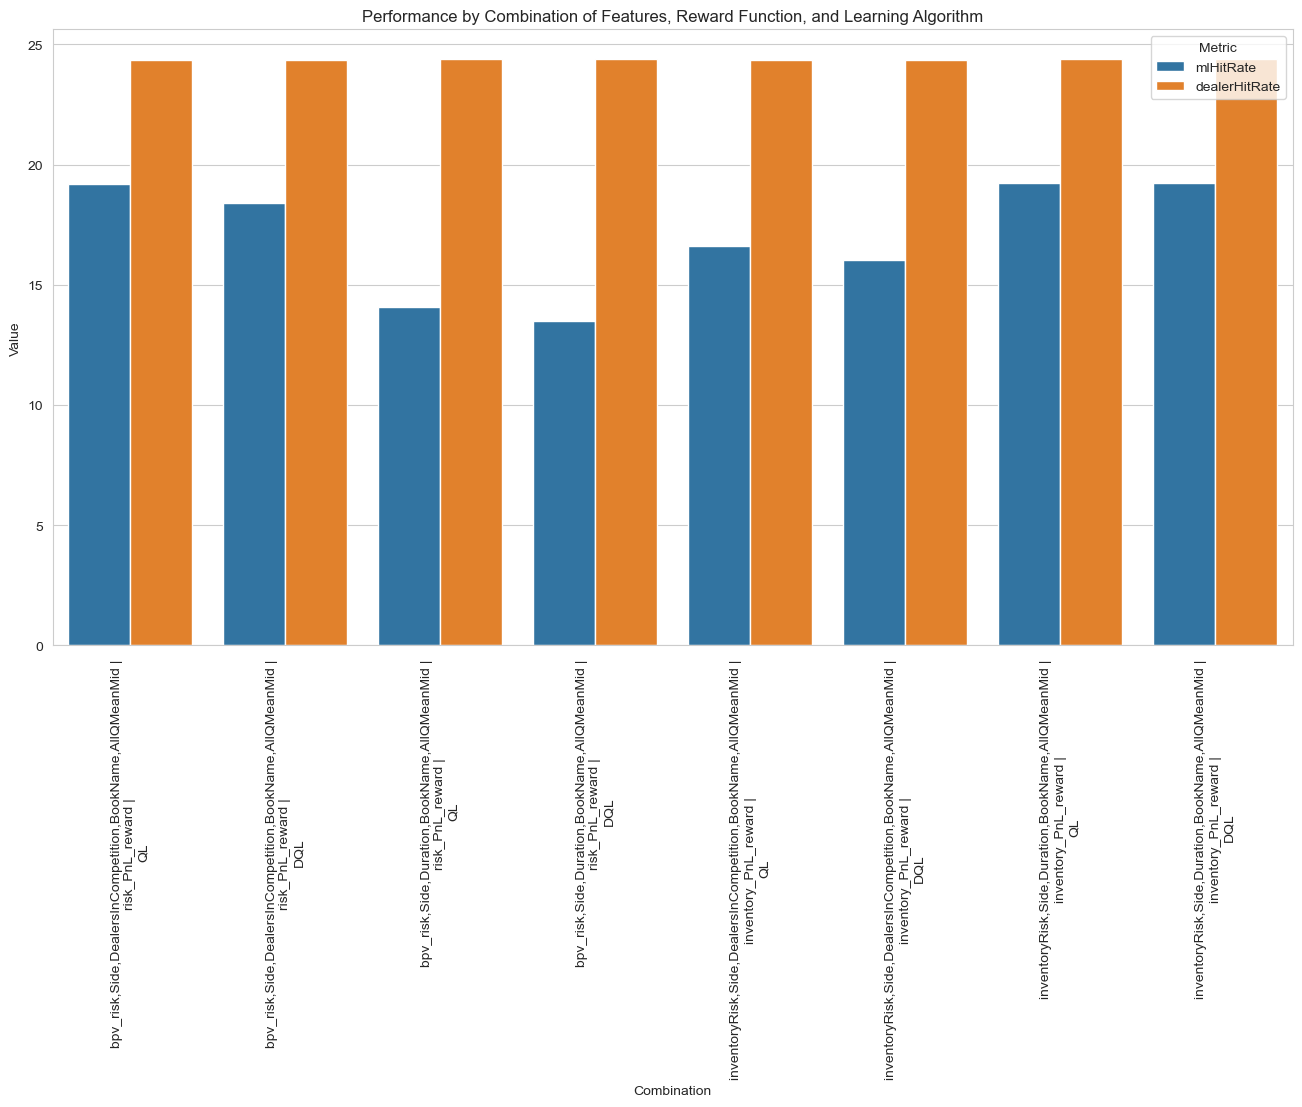

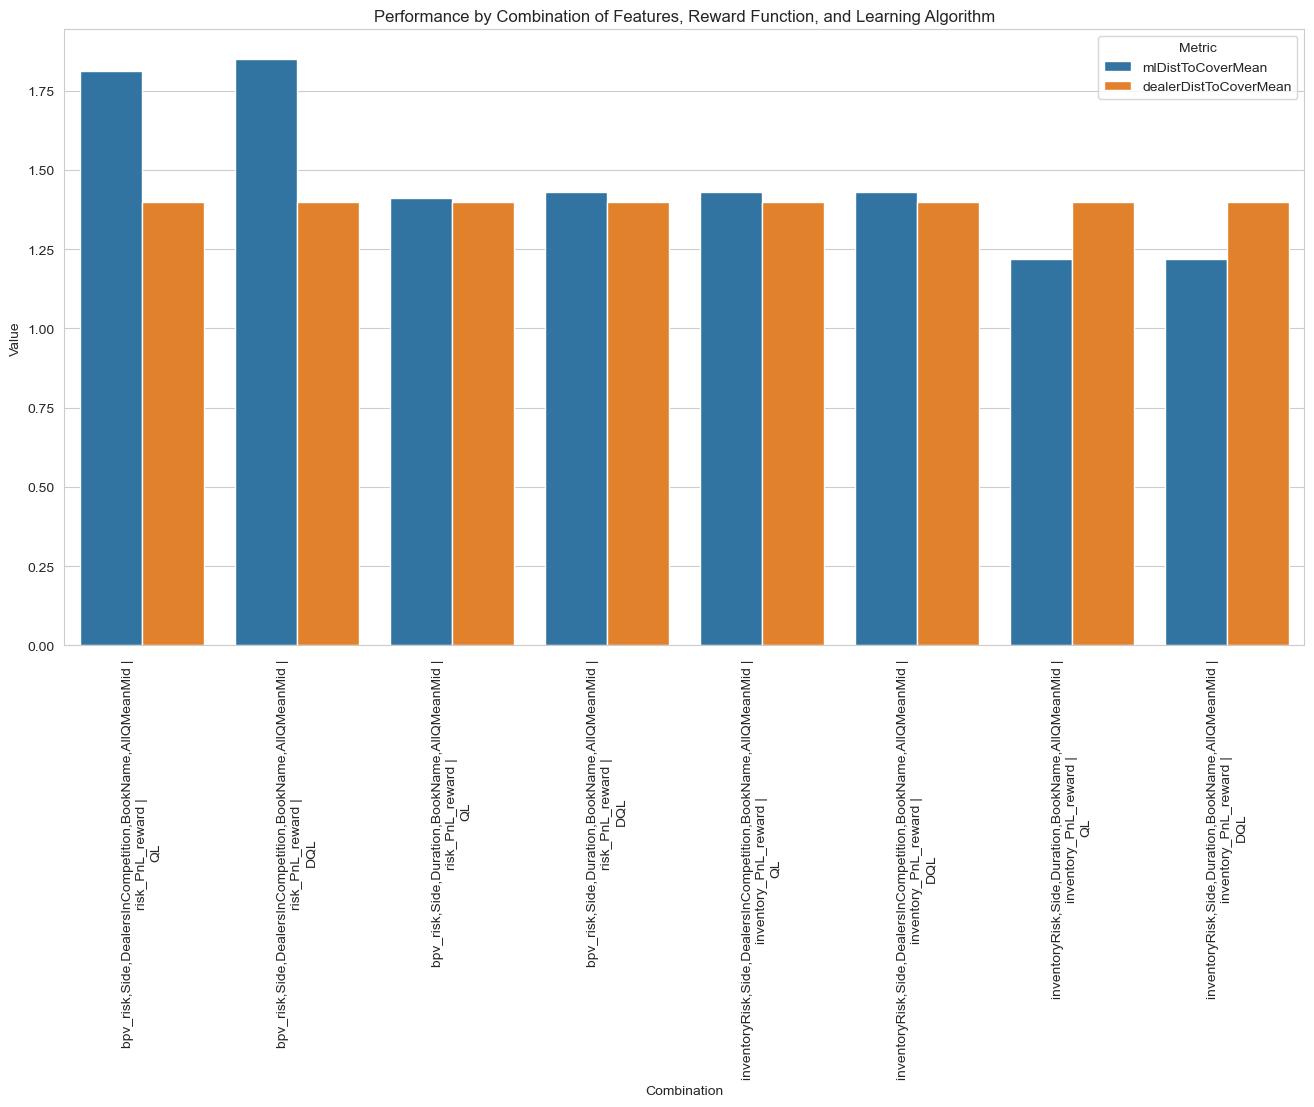

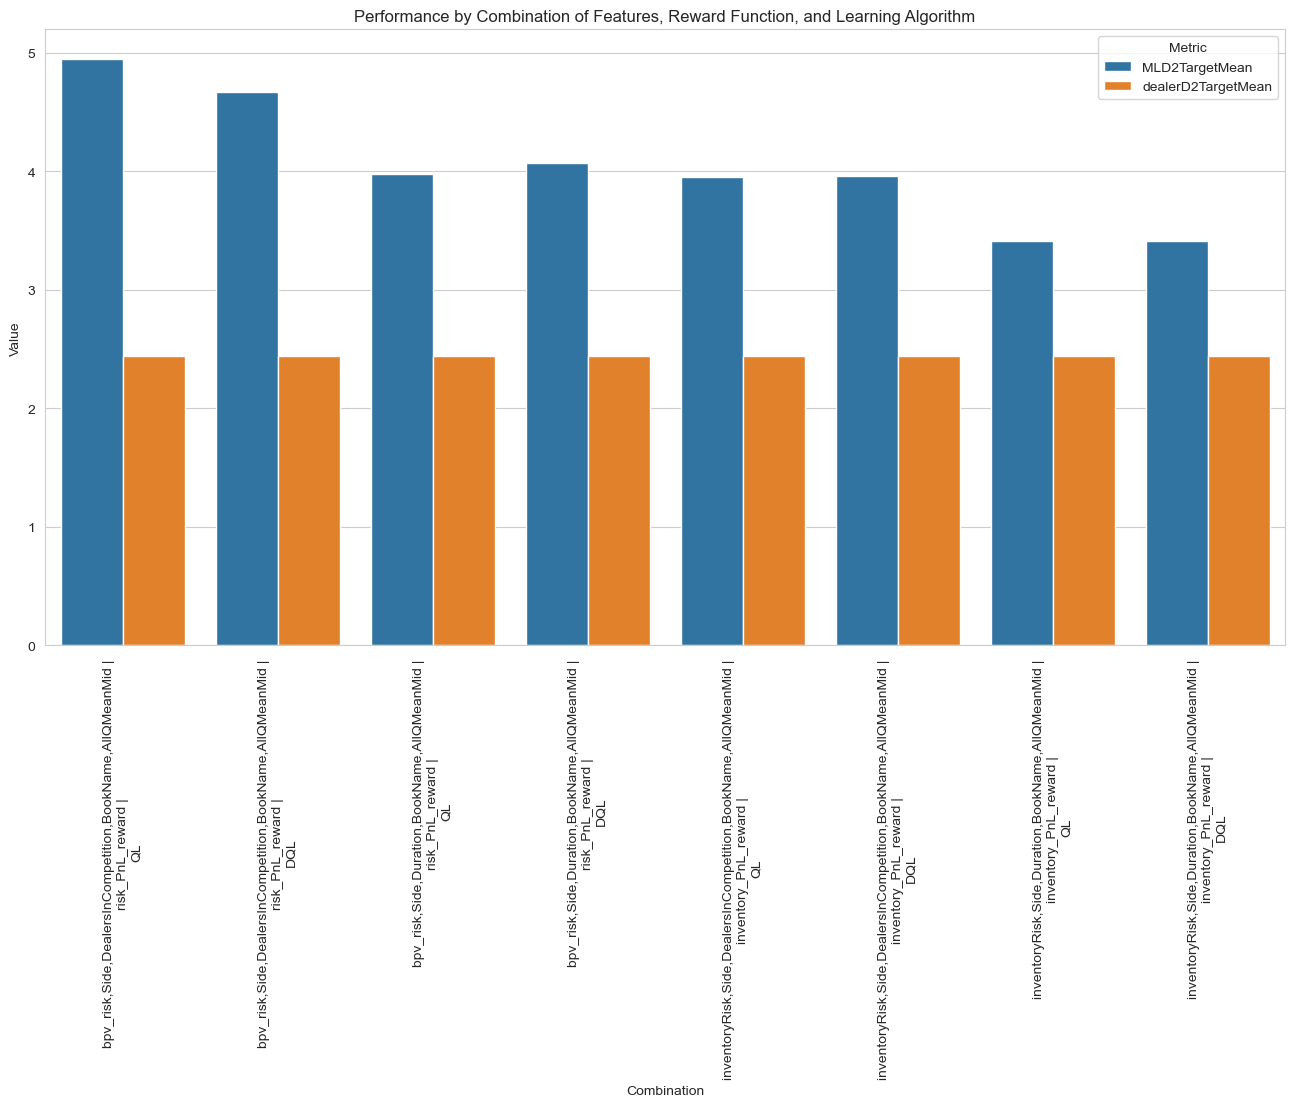

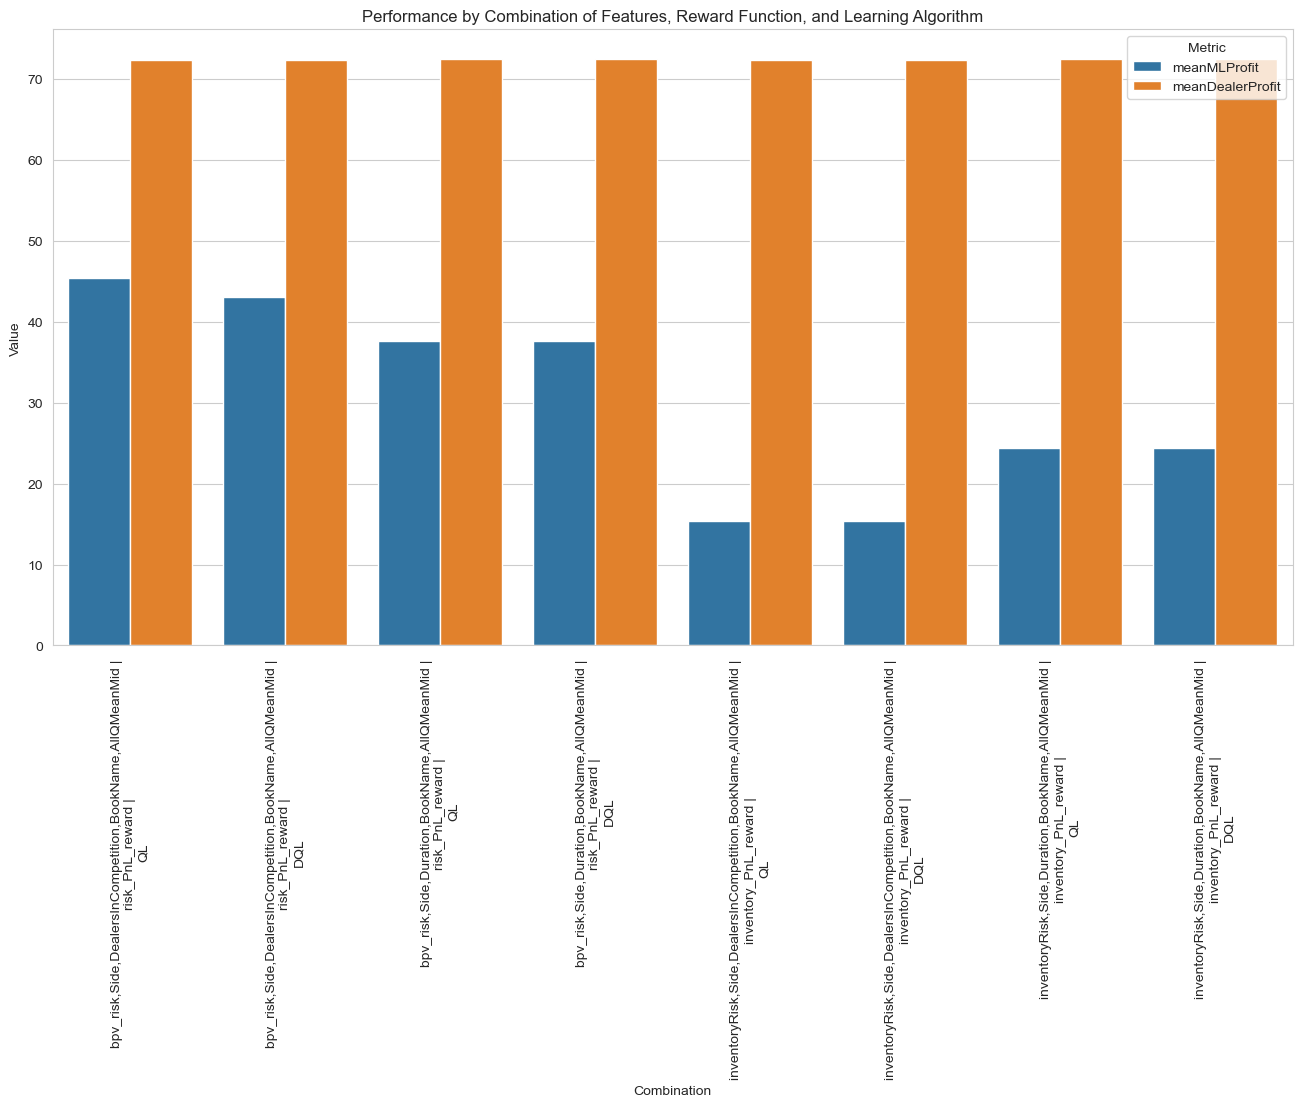

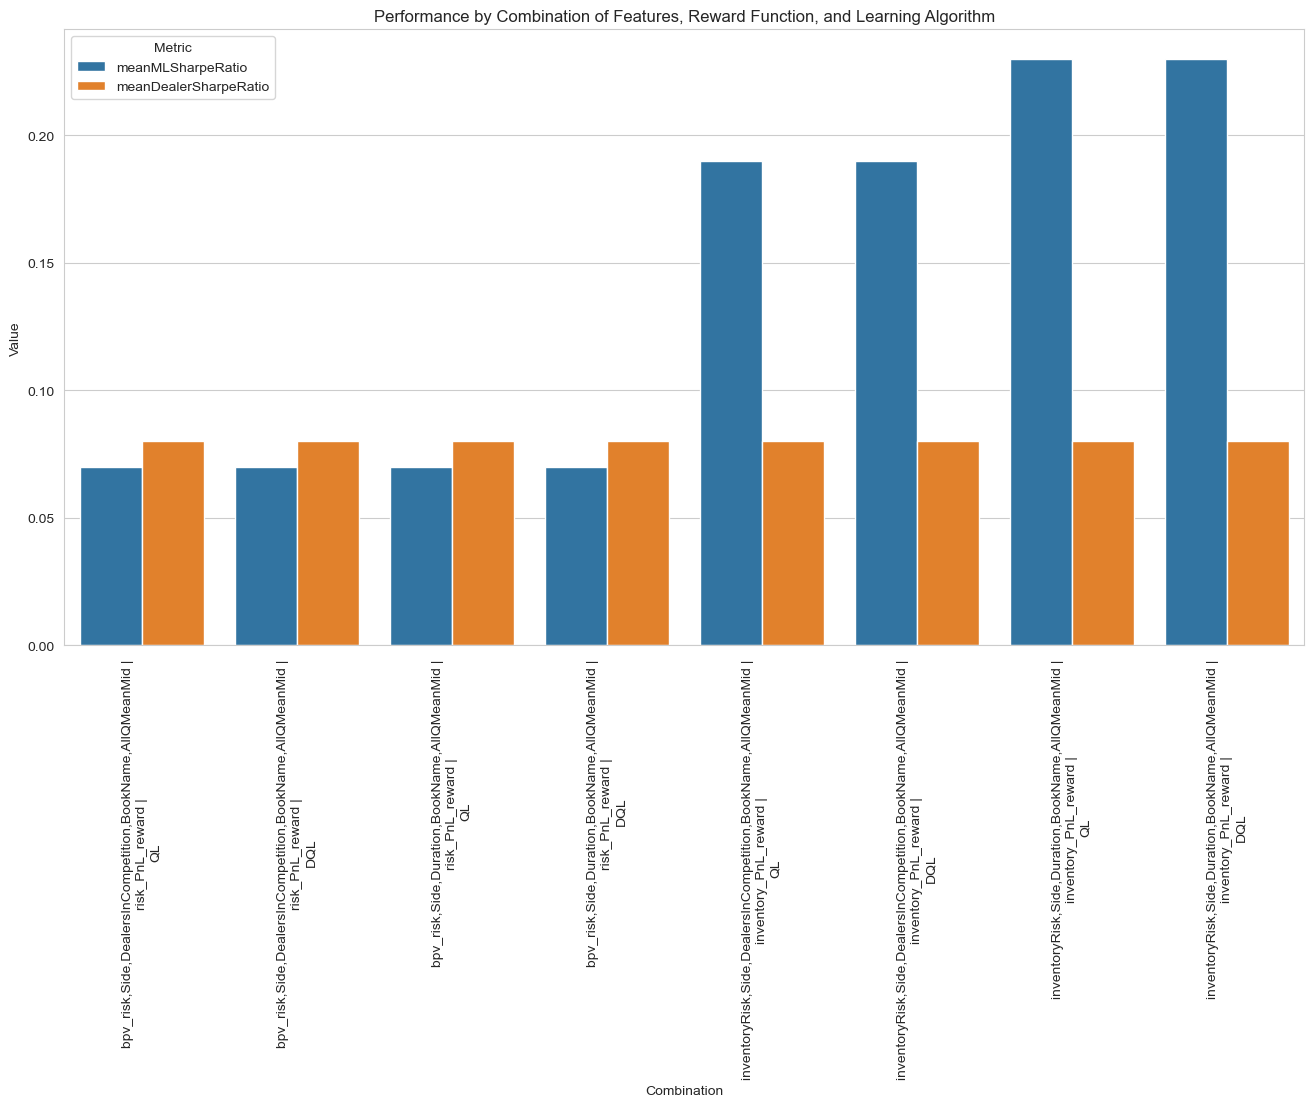

In [13]:
eval_utils.visualize_trader_vs_ML_metrics(results_df=results_df.copy())


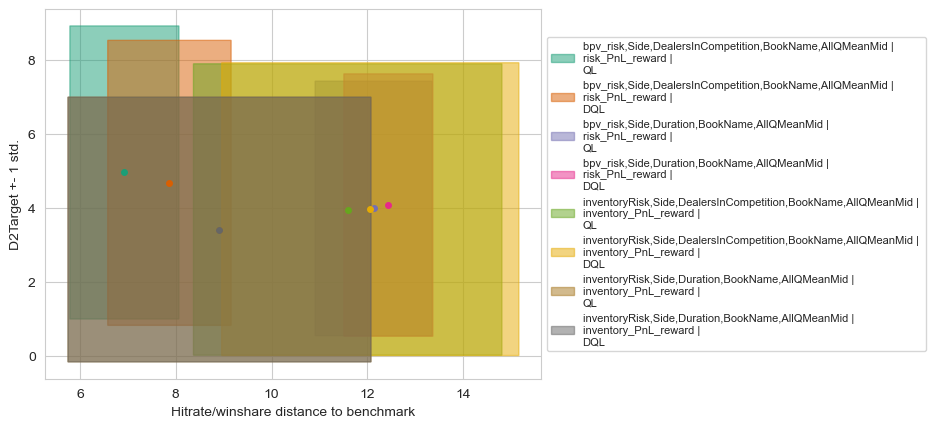

In [14]:
eval_utils.convex_hull(results_df.copy(), distance_measure="Target")